### Plots for CESM Workshop Talk

All maps are averaged over last year of a 20 year simulation.
Note that I just use `.mean("time")` and the data was originally monthly,
so I am not weighting the months correctly.
This is meant to be a rough plot of the current state.

All time series are generated from annual means.
Again, those annual means weight the monthly data incorrectly.

In [1]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib import colors
from matplotlib import pyplot as plt
# import nc_time_axis
import numpy as np
import xarray as xr

#### Helper functions

First cell are functions to read in the data.
Second cell generates plots.

In [2]:
def get_timeseries(filenames):
    ds = xr.open_mfdataset(filenames, parallel=False).compute().resample(time="Y").mean()
    return ds

def get_3d_datasets(filenames, isel_dict):
    # Open dataset, only interested in subset of variables
    vars_for_maps = ['ALK', 'spChl', 'diatChl', 'diazChl', 'coccoChl']
    ds = xr.open_mfdataset(filenames, decode_times=False)[vars_for_maps]
    
    # Store attributes because they get dropped during either isel or mean()
    attrs = dict()
    for var in ds.data_vars:
        attrs[var] = ds[var].attrs
    ds = ds.isel(isel_dict).mean('time').compute()
    for var in ds.data_vars:
        ds[var].attrs = attrs[var]

    # Sum individual Chl, only store total
    if all([var in ds.data_vars for var in ['spChl', 'diatChl', 'diazChl', 'coccoChl']]):
        ds['totChl'] = ds['spChl'] + ds['diatChl'] + ds['diazChl'] + ds['coccoChl']
        ds['totChl'].attrs = ds['spChl'].attrs
        ds['totChl'].attrs['long_name'] = 'Total Chlorophyll'
        ds = ds.drop(['spChl', 'diatChl', 'diazChl', 'coccoChl'])
    return ds

def update_units(ds, varname, scale_factor, new_units):
    ds_new = ds.copy(deep=True)
    ds_new[varname].data = ds[varname].data * scale_factor
    ds_new[varname].attrs['units'] = new_units
    return ds_new

In [3]:
def plot_mom_field(ds, varname, figsize=[9,4], cmap=cmocean.cm.thermal, title=None, filename=None, **plot_kwargs):
    if title is None:
        title = varname
    title = f'Surface {title}, MOM'
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
    ds[varname].plot(ax=ax, x="geolon", y="geolat", cmap=cmap, transform=ccrs.PlateCarree(), **plot_kwargs)
    ax.set_title(title)
    if filename is not None:
        plt.savefig(f'plots/{filename}')

def plot_pop_field(ds, varname, figsize=[9,4], cmap=cmocean.cm.thermal, title=None, filename=None, **plot_kwargs):
    if title is None:
        title = varname
    title = f'Surface {title}, POP'
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
    ds[varname].plot(ax=ax, x="TLONG", y="TLAT", cmap=cmap, transform=ccrs.PlateCarree(), **plot_kwargs)
    ax.set_title(title)
    if filename is not None:
        plt.savefig(f'plots/{filename}')

def plot_time_series(ds1, ds2, varname, figsize=[9,4], region='Global', legend=['MOM6+MARBL', 'POP2+MARBL'], ylim=None, title=None, subtitle=None, filename=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ds1[varname].sel(region=region).plot()
    ds2[varname].sel(region=region).plot()
    ax.set_ylim(ylim)
    if title is None:
        title = varname
    if subtitle is not None:
        title = f'{title}\n{subtitle}'
    plt.title(title)
    plt.legend(legend)
    if filename is not None:
        plt.savefig(f'plots/{filename}')

#### Read data

This will take a little time (less than a minute);
read the data from disk, drop unused variables, take annual means, and
do unit conversion for time series plots.

In [4]:
%%time

root_dir = '/glade/work/klindsay/analysis/MARBL-MOM/line_plots_data_cache'
mom_case = 'g.e23a12b.TL319_t061.G1850MOMMARBL_JRA.010'
pop_case = 'g.e23a12b.TL319_g17.G1850POPECO_JRA.4p2z'
mom_archive = f'/glade/scratch/mlevy/archive/{mom_case}/ocn/hist'
pop_archive = f'/glade/scratch/mlevy/archive/{pop_case}/ocn/hist'

# Read time series
mom_timeseries = get_timeseries(f'{root_dir}/{mom_case}.*.nc')
pop_timeseries = get_timeseries(f'{root_dir}/{pop_case}.*.nc')

# Unit conversion
mom_timeseries_new_units = update_units(mom_timeseries, 'photoC_TOT_zint', 1e-20 * (12*86400*365), 'Pg / yr')
mom_timeseries_new_units = update_units(mom_timeseries_new_units, 'photoC_diat_zint', 1e-20 * (12*86400*365), 'Pg / yr')
pop_timeseries_new_units = update_units(pop_timeseries, 'photoC_TOT_zint', 1e-24 * (12*86400*365), 'Pg / yr')
pop_timeseries_new_units = update_units(pop_timeseries_new_units, 'photoC_diat_zint', 1e-24 * (12*86400*365), 'Pg / yr')

# Read surface data
mom_final_year = get_3d_datasets(f'{mom_archive}/{mom_case}.mom6.h_bgc_monthly_z_0020_*.nc', isel_dict={'z_pop_l':0})
pop_final_year = get_3d_datasets(f'{pop_archive}/{pop_case}.pop.h.0020-*.nc', isel_dict={'z_t': 0, 'z_t_150m': 0}).drop_vars(['ULONG', 'ULAT'])

# Add geolat and geolon to mom_final_year
mom_static = xr.open_dataset(f'{mom_archive}/{mom_case}.mom6.static.nc')
mom_final_year = mom_final_year.assign_coords({'geolat': mom_static['geolat'], 'geolon': mom_static['geolon']})

CPU times: user 14.5 s, sys: 1.75 s, total: 16.3 s
Wall time: 29.9 s


#### Plots

Time series of NPP and diatom contribution to NPP.
Maps of surface values of alkalinity and chlorophyll.

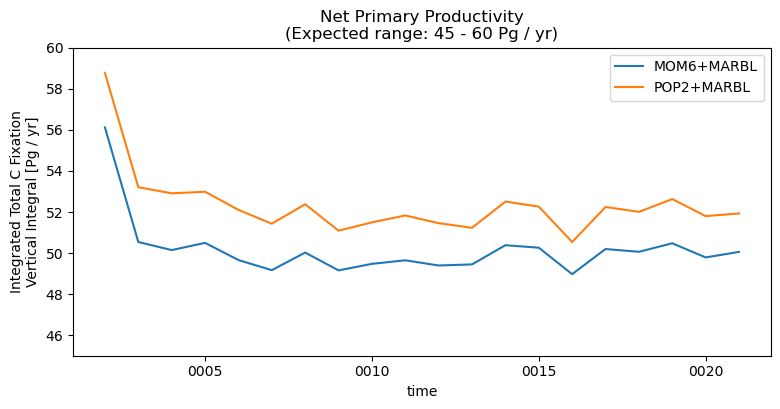

In [5]:
plot_time_series(mom_timeseries_new_units,
                 pop_timeseries_new_units,
                 'photoC_TOT_zint',
                 ylim=[45,60],
                 title='Net Primary Productivity',
                 subtitle='(Expected range: 45 - 60 Pg / yr)',
                 filename='NPP.png')

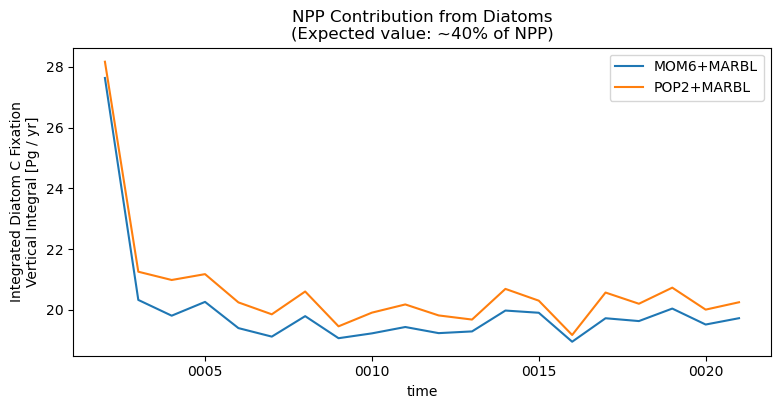

In [6]:
plot_time_series(mom_timeseries_new_units,
                 pop_timeseries_new_units,
                 'photoC_diat_zint',
                 title='NPP Contribution from Diatoms',
                 subtitle='(Expected value: ~40% of NPP)',
                 filename='diatNPP.png')

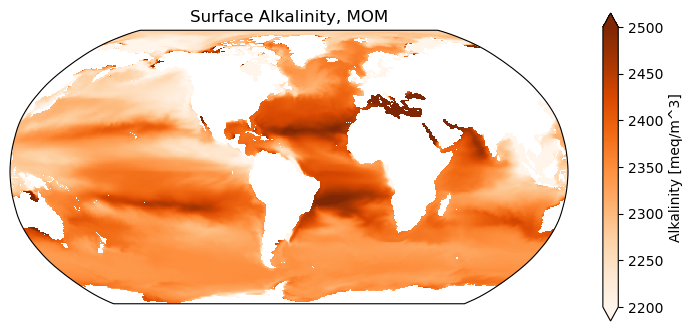

In [7]:
plot_mom_field(mom_final_year, 'ALK', title="Alkalinity", vmin=2200, vmax=2500, cmap="Oranges", filename='MOM_ALK.png')

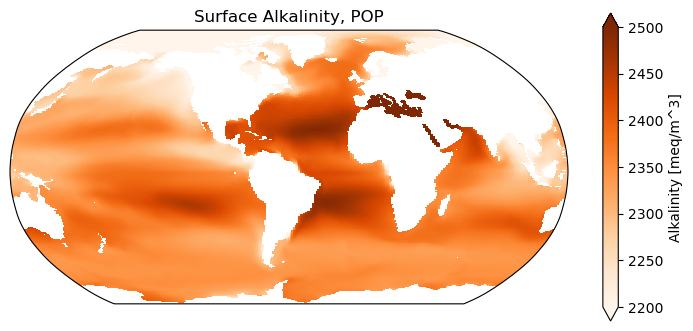

In [8]:
plot_pop_field(pop_final_year, 'ALK', title="Alkalinity", vmin=2200, vmax=2500, cmap="Oranges", filename='POP_ALK.png')

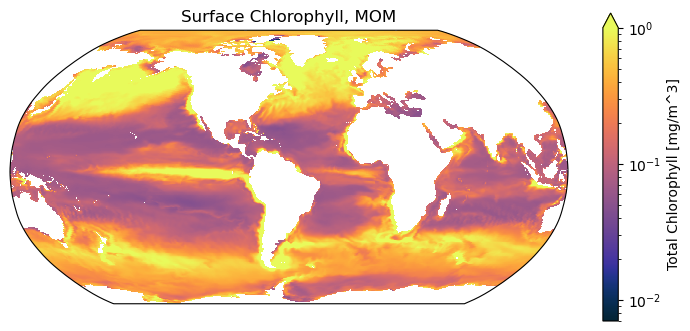

In [9]:
plot_mom_field(mom_final_year, 'totChl', title="Chlorophyll", norm=colors.LogNorm(vmin=7e-3, vmax=1), filename='MOM_Chl.png')

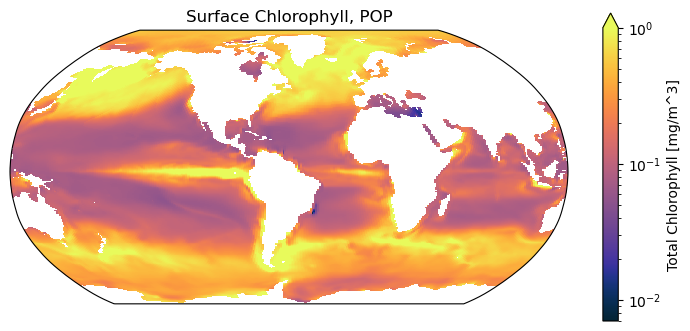

In [10]:
plot_pop_field(pop_final_year, 'totChl', title="Chlorophyll", norm=colors.LogNorm(vmin=7e-3, vmax=1), filename='POP_Chl.png')